# Assignment - Recommendation Systems

## Assignment Objective
You are the sales manager for "BeerMart", an online beer store in the United States. You want to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy. You collect data about the ratings that the customers have given in the past.

## Steps Involved
As you solve the case study, you need to complete the following tasks:

1. Data preparation
  Choose only those beers that have at least N number of reviews.
  1. Figure out an appropriate value of N using EDA; this may not have one correct answer, but you should not choose beers that have an extremely low number of ratings.

2. Data exploration
  1. What are the unique values of ratings?
  2. Visualise the rating values and notice:
    - The average beer ratings
    - The average user ratings
    - The average number of ratings given to the beers
    - The average number of ratings given by the users

3. Recommendation Models
  - Divide your data into training and testing dataset.
  - Build user-based and item-based models.
  - Determine how similar the first 10 users are to each other and visualise it.
  - Compute and visualise the similarity between the first 10 beers.
  - Compare the performance of the two models using test data and suggest the one that should be deployed.
  - Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

In [0]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
# Reading ratings file
df_data = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/3f1237da-dbc5-434b-8ea4-c4bf43dbfd42/beer_data.csv')

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
beer_beerid           475984 non-null int64
review_profilename    475884 non-null object
review_overall        475984 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ MB


In [3]:
# Downcasting to optimally utilize memory, and thus save RAM usage
df_data = df_data.astype({"beer_beerid": np.int32, "review_overall": np.float32})

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
beer_beerid           475984 non-null int32
review_profilename    475884 non-null object
review_overall        475984 non-null float32
dtypes: float32(1), int32(1), object(1)
memory usage: 7.3+ MB


In [4]:
df_data.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


## Data preparation: Performing EDA & Obtaining Filtered Dataset

In [5]:
# Counting Null values
df_data.isna().sum()

beer_beerid             0
review_profilename    100
review_overall          0
dtype: int64

In [0]:
# Dropping Null values since the count of null values is very small
df_data.dropna(inplace=True)

In [0]:
# Dropping Duplicate Rows (considering all rows)
df_data.drop_duplicates(inplace=True)

In [0]:
# Dropping Duplicate Reviews (where user gave multiple reviews to same beer, considering the highest value)
df_data = df_data.sort_values('review_overall').drop_duplicates(subset=['beer_beerid', 'review_profilename'], keep='last')

In [9]:
# Analysing column 'beer_beerid'
print(f'Count of unique beers: {len(df_data.beer_beerid.unique())}')

Count of unique beers: 40304


In [10]:
# Analysing column 'review_profilename'
df_data.review_profilename.describe()

count             474462
unique             22497
top       northyorksammy
freq                1842
Name: review_profilename, dtype: object

In [11]:
# Analysing column 'review_overall'
df_data.review_overall.describe()

count    474462.000000
mean          3.814926
std           0.719243
min           0.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: review_overall, dtype: float64

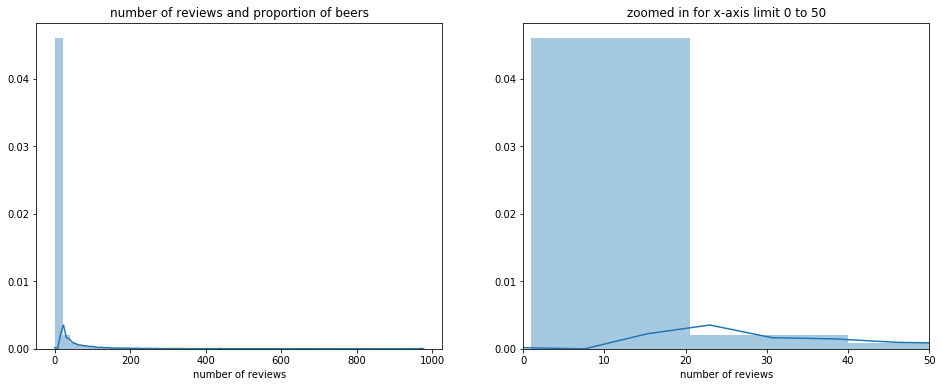

In [12]:
# Visualizing the number of reviews and proportion of beers falling in that category.
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title('number of reviews and proportion of beers')
ax1.set_xlabel('number of reviews')
ax2.set_xlim([0, 50])
ax2.set_title('zoomed in for x-axis limit 0 to 50')
ax2.set_xlabel('number of reviews')

sns.distplot(df_data.groupby('beer_beerid').size(), ax=ax1)
sns.distplot(df_data.groupby('beer_beerid').size(), ax=ax2)

count    40304.000000
mean        11.772082
std         41.888449
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        977.000000
dtype: float64

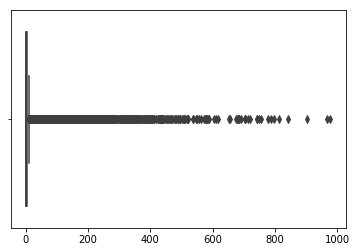

In [13]:
# Visualizing the same using a box plot
sns.boxplot(x=df_data.groupby('beer_beerid').size())
df_data.groupby('beer_beerid').size().describe()

In [14]:
# Computing average number of reviews per beer (approx 12)
anrpb = df_data.groupby('beer_beerid').size().mean()
print(f'Average number of reviews per beer: {anrpb:.2f}')

# Computing list of popular beer; beer having more than 5 reviews (>75th percentile of average number of reviews per beer)
popular_beers = df_data.groupby('beer_beerid').size()
popular_beers[popular_beers > 5].count()

# Removing data of beer that have less than or equal to 5 reviews
df_data_popular = df_data[df_data.beer_beerid.isin(popular_beers[popular_beers > 5].index)]
df_data_popular.head()

Average number of reviews per beer: 11.77


,beer_beerid,review_profilename,review_overall
96621,28107,Weizenmensch,1.0
270311,5345,HCYJ,1.0
391788,52480,hardy008,1.0
391791,52480,giblet,1.0
393265,3734,PhxHorn,1.0


## Data Exploration: Overviewing Filtered Data

The unique values of ratings are: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


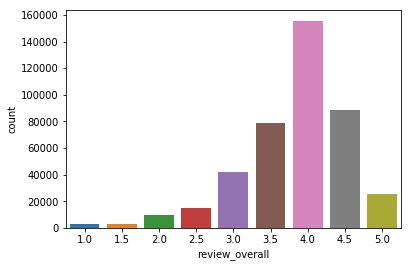

In [15]:
# What are the unique values of ratings?
sns.countplot(x='review_overall', data=df_data_popular)
print(f'The unique values of ratings are: {sorted(list(df_data_popular["review_overall"].unique()))}')

 Average beer rating: 3.7303504943847656
 Average user rating: 3.9176900386810303
 Average number of ratings given to the beers: 43.26942471956365
 Average number of ratings given by the users: 19.399667789415403


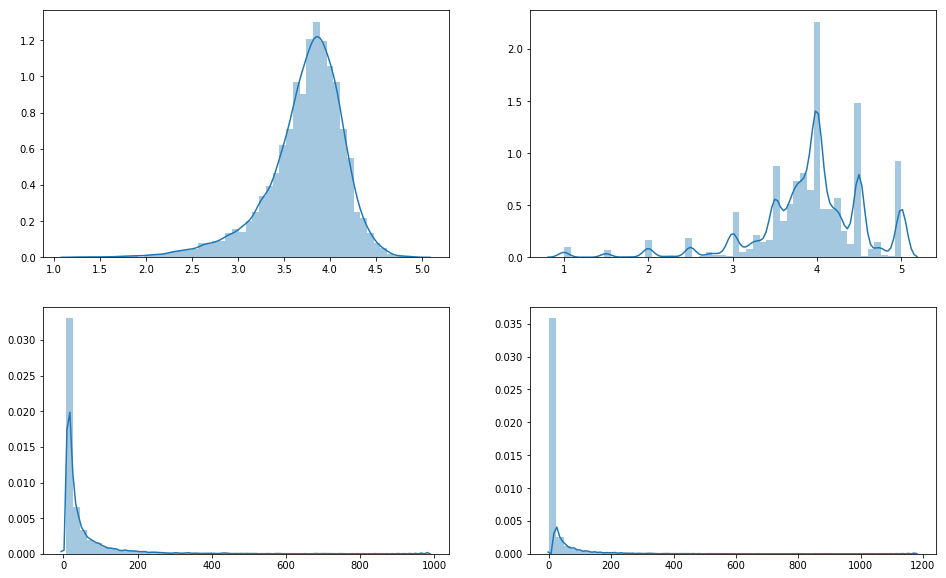

In [16]:
# Visualise the rating values and notice:
# 1. The average beer ratings
# 2. The average user ratings
# 3. The average number of ratings given to the beers
# 4. The average number of ratings given by the users

f, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sns.distplot(df_data_popular[["beer_beerid", "review_overall"]].groupby(["beer_beerid"]).mean(), ax=ax1)
sns.distplot(df_data_popular[["review_profilename", "review_overall"]].groupby(["review_profilename"]).mean(), ax=ax2)
sns.distplot(df_data_popular.groupby(["beer_beerid"]).size(), ax=ax3)
sns.distplot(df_data_popular.groupby(["review_profilename"]).size(), ax=ax4)

print(f' Average beer rating: {(df_data_popular[["beer_beerid", "review_overall"]].groupby(["beer_beerid"]).mean()).mean()[0]}')
print(f' Average user rating: {(df_data_popular[["review_profilename", "review_overall"]].groupby(["review_profilename"]).mean()).mean()[0]}')
print(f' Average number of ratings given to the beers: {df_data_popular.groupby(["beer_beerid"]).size().mean()}')
print(f' Average number of ratings given by the users: {df_data_popular.groupby(["review_profilename"]).size().mean()}')

## Dividing data into Test and Train Split

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_data_popular, test_size=0.30, random_state=31)

In [18]:
print(train.shape)
print(test.shape)
print(sys.getsizeof(train)/(1024*1024))
print(sys.getsizeof(test)/(1024*1024))

(294314, 3)
(126135, 3)
23.00956153869629
9.86103630065918


In [0]:
# pivot beer ratings for users
df_user_beer_rating = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [20]:
df_user_beer_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,...,74591,74625,74634,74640,74759,74783,74815,74827,74854,74898,74900,74904,74906,74942,74967,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75559,75623,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01Ryan10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04101Brewer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0beerguy0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Copy train and test dataset
These dataset will be used for prediction and evaluation. 
- Dummy train will be used later for prediction of the beers which has not been rated by the user. To ignore the beers rated by the user, we will mark it as 0 during prediction. The beers not rated by user is marked as 1 for prediction. 
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [0]:
dummy_train = train.copy()
dummy_test = test.copy()

In [0]:
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [23]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

dummy_train.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,...,74591,74625,74634,74640,74759,74783,74815,74827,74854,74898,74900,74904,74906,74942,74967,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75559,75623,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01Ryan10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
04101Brewer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0beerguy0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

dummy_test.head()

beer_beerid,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,63,...,74530,74548,74579,74582,74591,74625,74634,74640,74759,74783,74815,74827,74854,74900,74904,74906,74942,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0runkp0s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000Bottles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Recommendation Models

## User Based Similarity

### Using Cosine Similarity

In [25]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_user_beer_rating, metric='cosine', n_jobs=-1)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [26]:
user_correlation.shape

(19054, 19054)

## Using adjusted Cosine 

### Here, not removing the NaN values and calculating the mean only for the beers rated by the user

In [0]:
user_beer_rating = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [28]:
user_beer_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,...,74591,74625,74634,74640,74759,74783,74815,74827,74854,74898,74900,74904,74906,74942,74967,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75559,75623,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01Ryan10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the beers for each user aroung 0 mean

In [0]:
mean = np.nanmean(user_beer_rating, axis=1)
df_subtracted = (user_beer_rating.T-mean).T

In [30]:
df_subtracted.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,...,74591,74625,74634,74640,74759,74783,74815,74827,74854,74898,74900,74904,74906,74942,74967,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75559,75623,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01Ryan10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [31]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine', n_jobs=-1)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0.99999994 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


## Prediction

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [32]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0.99999994, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

Rating predicted by the user (for beers rated as well as not rated) is the weighted sum of correlation with the beer rating (as present in the rating dataset). 

In [33]:
user_predicted_ratings = np.dot(user_correlation, user_beer_rating.fillna(0))
user_predicted_ratings

array([[0.01190925, 0.8191598 , 1.810013  , ..., 0.        , 0.35515618,
        0.1530276 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.15948427, 2.2265902 , 5.9478393 , ..., 0.07432657, 0.23665977,
        0.66345704],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01650301, 0.89314795, 4.7228775 , ..., 0.        , 0.01886058,
        0.08926892]], dtype=float32)

In [34]:
user_predicted_ratings.shape

(19054, 9715)

Since we are interested only in the beers not rated by the user, we will ignore the beers rated by the user by making it zero. 

In [35]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,...,74591,74625,74634,74640,74759,74783,74815,74827,74854,74898,74900,74904,74906,74942,74967,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75559,75623,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.011909,0.819160,1.810013,1.271499,0.101582,0.127594,1.904636,0.111820,0.082806,0.080132,0.172859,0.382497,2.042159,1.613757,0.103910,0.321188,0.406985,0.054345,0.152687,0.134571,0.047081,5.344230,2.046464,0.543167,4.511248,9.371899,1.572157,8.845065,0.168762,0.0,0.177473,0.147609,0.202215,0.081478,0.844220,0.730697,0.378759,1.698431,3.101893,5.113503,...,0.088664,0.159365,0.151110,0.133328,0.143581,0.235591,0.720775,0.590766,0.003156,0.232794,0.004652,0.402254,0.165106,0.147632,0.061217,1.957705,0.012754,0.501752,0.629574,0.105196,0.712618,0.207406,0.257131,0.000000,0.014115,0.243960,0.311499,0.083793,0.231269,0.199299,0.898430,0.00000,0.0,0.252956,0.001852,0.357704,0.166136,0.000000,0.355156,0.153028
01Ryan10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
04101Brewer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
05Harley,0.026157,1.349248,3.869729,2.792523,0.250221,0.373820,2.867416,0.250218,0.766112,0.181778,0.432285,0.685711,4.543994,2.033609,0.133228,0.619384,0.400734,0.286149,0.441802,0.056938,0.131394,8.175587,3.226968,1.425238,6.879306,14.556154,2.669400,9.841736,0.041533,0.0,0.208389,0.371386,0.533242,0.287198,0.404087,1.850058,0.625270,2.121576,8.107262,6.612947,...,0.250484,0.142382,0.599030,0.000000,0.423252,0.293509,0.149215,0.934383,0.027970,0.370234,0.000000,0.520369,0.125146,0.344049,0.078001,6.657939,0.380327,2.782651,0.037532,0.064606,2.750193,0.065344,0.751017,0.233251,0.085387,0.150331,0.292029,0.182576,0.435408,0.569531,0.921337,0.06589,0.0,0.437451,0.035971,0.350737,0.000000,0.008271,0.509215,0.740447
0beerguy0,0.042697,0.912055,1.431643,1.329023,1.305894,0.127638,1.929037,0.144144,0.139752,0.136003,0.448738,0.231257,2.090183,0.680466,0.088820,0.007528,0.705639,0.151514,0.281690,1.545006,0.048797,2.768512,3.457515,1.245451,4.637183,4.336920,1.606650,1.555442,0.000000,0.0,0.956464,0.000000,0.343575,0.248830,0.574500,0.432354,0.052800,1.394239,2.434622,3.473279,...,0.079045,0.000000,0.091082,0.115415,0.000000,0.092815,0.000000,0.139390,0.000000,0.000000,0.000000,0.042697,0.043624,0.064248,0.029962,0.683454,0.013603,0.153335,0.000000,0.223064,0.261563,0.011405,0.156753,0.071331,0.000000,0.000000,0.000000,0.000000,0.018459,0.000000

### Finding the top 5 recommendation for the user 1 

In [36]:
user_final_rating.iloc[1].sort_values(ascending=False)[0:5]

beer_beerid
76816    0.0
10526    0.0
10514    0.0
10496    0.0
10484    0.0
Name: 01Ryan10, dtype: float64

## Visualizing Similarity of first 10 Users

In [37]:
# Visualizing similarity of the first 10 users for top 5 recommended beers each
user_likes = {}
for i in range(10):
  user_likes[user_final_rating.columns[i]] = list(user_final_rating.iloc[i].sort_values(ascending=False)[0:5].index)

user_likes

{4: [17112, 7971, 412, 19960, 1160],
 5: [76816, 10526, 10514, 10496, 10484],
 6: [76816, 10526, 10514, 10496, 10484],
 7: [17112, 11757, 1093, 412, 19960],
 8: [731, 6108, 695, 2093, 412],
 9: [1093, 17112, 2093, 11757, 88],
 10: [1717, 646, 88, 1708, 18862],
 11: [76816, 10526, 10514, 10496, 10484],
 12: [7971, 2671, 2093, 1904, 11757],
 13: [76816, 10526, 10514, 10496, 10484]}

**Summary**:
1. User 1 and 4 seems alike on basis of recommended beer
2. User 2, 3, 8 and 10 seems alike on basis of recommended beer

# Item Based Similarity

Using Correlation

Taking the transpose of the rating matrix to normalize the rating around the mean for different beer ID. In the user based similarity, we had taken mean for each user intead of each beer. 

In [38]:
user_beer_rating = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

user_beer_rating.head()

review_profilename,0110x011,01Ryan10,04101Brewer,05Harley,0beerguy0,0tt0,1000Bottles,1001111,100floods,1050Sudz,108Dragons,1099,10bear,1121987,11millsown113,11osixBrew,11thFloorBrewing,12percent,12vUnion,12vman,130guy,13smurrf,160Shillings,1759Girl,1759dallas,18alpha,1996StrokerKid,1Adam12,1BeerLeague,1PA,1after909,1bigwoody,1fastz28,1joeyjojo,1morebeer,1noa,1quiks10,1realbeer,1santore,1thinmint,...,ziggycash,zimm421,zimmerbloke,zipyth3pinhead,zjungleist,zlackoff,zloew,zminor,zms101,znarf,znichols,zodiacv1,zodiak3000,zooalbert,zooga,zook74,zoolou,zoolzoo,zornbeast,zorro5683,zoso1967,zoso493,zplug123,zrab11,zseeanz,zsk,ztaylor1,ztoellner,ztprez,ztruempy,zuccard,zuffenhausen,zuggy9,zulufactor,zumicroom,zwan,zymrgy,zymurgy4all,zymurgywhiz,zyzygy
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the beer rating for each beer

In [0]:
mean = np.nanmean(user_beer_rating, axis=1)
df_subtracted = (user_beer_rating.T-mean).T

In [40]:
df_subtracted.head()

review_profilename,0110x011,01Ryan10,04101Brewer,05Harley,0beerguy0,0tt0,1000Bottles,1001111,100floods,1050Sudz,108Dragons,1099,10bear,1121987,11millsown113,11osixBrew,11thFloorBrewing,12percent,12vUnion,12vman,130guy,13smurrf,160Shillings,1759Girl,1759dallas,18alpha,1996StrokerKid,1Adam12,1BeerLeague,1PA,1after909,1bigwoody,1fastz28,1joeyjojo,1morebeer,1noa,1quiks10,1realbeer,1santore,1thinmint,...,ziggycash,zimm421,zimmerbloke,zipyth3pinhead,zjungleist,zlackoff,zloew,zminor,zms101,znarf,znichols,zodiacv1,zodiak3000,zooalbert,zooga,zook74,zoolou,zoolzoo,zornbeast,zorro5683,zoso1967,zoso493,zplug123,zrab11,zseeanz,zsk,ztaylor1,ztoellner,ztprez,ztruempy,zuccard,zuffenhausen,zuggy9,zulufactor,zumicroom,zwan,zymrgy,zymurgy4all,zymurgywhiz,zyzygy
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value. 

In [41]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine', n_jobs=-1)
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 9.9999988e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   5.4923296e-03  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00 -2.7037263e-02 ...  4.3718040e-02
  -4.4274330e-03 -3.0827522e-04]
 [ 0.0000000e+00 -2.7037263e-02  1.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.3794055e-02]
 ...
 [ 0.0000000e+00  4.3718040e-02  0.0000000e+00 ...  9.9999994e-01
  -3.0382156e-02  0.0000000e+00]
 [ 5.4923296e-03 -4.4274330e-03  0.0000000e+00 ... -3.0382156e-02
   1.0000000e+00  3.3884418e-01]
 [ 0.0000000e+00 -3.0827522e-04 -2.3794055e-02 ...  0.0000000e+00
   3.3884418e-01  9.9999994e-01]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [42]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0.9999999 , 0.        , 0.        , ..., 0.        , 0.00549233,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.04371804, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04371804, 0.        , ..., 0.99999994, 0.        ,
        0.        ],
       [0.00549233, 0.        , 0.        , ..., 0.        , 1.        ,
        0.33884418],
       [0.        , 0.        , 0.        , ..., 0.        , 0.33884418,
        0.99999994]], dtype=float32)

# Prediction

In [43]:
item_predicted_ratings = np.dot((user_beer_rating.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.15999627, 0.4109586 , 1.0506219 , ..., 0.01852065, 0.06246805,
        0.2010287 ],
       [0.        , 0.        , 0.07905573, ..., 0.        , 0.        ,
        0.25212228],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3227448 , 1.1405524 , 1.0825092 , ..., 0.27420706, 0.05842078,
        0.3226526 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01004124, 0.15845227, 0.0925386 , ..., 0.04981494, 0.00562525,
        0.        ]], dtype=float32)

In [44]:
item_predicted_ratings.shape

(19054, 9715)

In [45]:
dummy_train.shape

(19054, 9715)

### Filtering the rating only for the beers not rated by the user for recommendation

In [46]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,...,74591,74625,74634,74640,74759,74783,74815,74827,74854,74898,74900,74904,74906,74942,74967,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75559,75623,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.159996,0.410959,1.050622,1.089792,0.213678,0.343435,0.423104,0.407733,1.112892,0.067967,0.296018,0.917571,0.411835,0.428273,0.219842,0.504299,0.226941,0.301995,0.275713,0.123137,0.721261,1.605427,0.843561,0.629368,0.671981,0.623615,1.030651,0.773795,0.286601,0.000000,0.098133,1.001341,0.855574,0.343882,0.655111,0.901094,0.278798,0.950377,0.730116,0.431552,...,0.542999,0.892374,0.083074,0.326479,0.350037,0.051289,0.210671,0.389859,0.748081,1.225207,0.0,0.170008,0.078988,0.371719,0.049430,0.503266,0.834592,2.645093,0.000000,0.00000,1.009460,0.215558,1.077055,0.000000,0.361853,0.617936,0.175086,0.540593,0.683793,0.894811,3.428362,0.000000,0.118511,1.069237,0.0,1.342866,0.370915,0.018521,0.062468,0.201029
01Ryan10,0.000000,0.000000,0.079056,0.000000,0.000000,0.128226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074669,0.066466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019942,0.051297,0.000000,0.000000,0.106122,0.218428,0.045237,0.000000,0.000000,0.000000,0.000000,0.000000,0.030644,0.047748,0.000000,0.000000,0.000000,0.187625,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027051,0.000000,0.000000,0.000000,0.000000,0.0,0.045819,0.000000,0.027790,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.014697,0.152225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095501,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.252122
04101Brewer,0.000000,0.000000,0.000000,0.090781,0.091873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140600,0.000000,0.084030,0.117142,0.000000,0.015415,0.001222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059182,0.000000,0.052012,0.036504,0.000000,...,0.179378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055778,0.136458,0.00000,0.050404,0.078423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.259818,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
05Harley,0.189828,0.227278,0.813711,0.717141,0.367461,0.618560,0.962969,0.877355,0.784213,0.060714,0.339243,1.248404,0.680801,0.517763,0.920716,0.692116,0.265686,0.126547,0.458841,0.575887,0.643102,0.838488,0.855689,1.375576,0.864844,1.070756,0.945451,0.742651,0.183103,0.013793,0.116970,0.378611,0.273115,0.230927,0.408516,0.512362,0.339763,0.661233,0.713541,0.541643,...,0.392876,0.466551,0.593044,0.100681,0.675827,0.479336,0.632020,0.714378,0.331167,0.534498,0.0,0.338261,0.281588,0.270866,0.346005,0.634549,0.056043,1.861786,1.103333,0.04955,0.777942,0.277438,1.700861,0.094469,0.636940,0.438567,1.629039,0.029458,0.025136,0.531325,0.444053,0.000000,0.000000,0.844027,0.0,1.616205,0.370798,0.000000,0.150598,0.116408
0beerguy0,0.000000,0.155847,0.204516,0.071062,0.138362,0.032040,0.460464,1.256289,0.089290,0.066863,0.052674,0.110041,0.225844,0.000000,0.000000,0.022993,0.134848,0.041919,0.059283,0.000000,0.829868,0.046331,0.051325,0.279034,0.255399,0.075501,0.098509,0.325581,0.000000,0.000000,0.114299,0.000000,0.000000,0.000000,0.054213,0.027039,0.268905,0.027227,0.050415,0.026515,...,0.146964,0.000000,0.073668,0.000000,0.000000,0.017820,0.000000,0.000000,0.030321,0.000000,0.0,0.042763,0.123841,0.020039,0.047352,0.059286,0.007798,0.154758,0.000000,0.00000,0.027109,0.000000,0.192405,0.019082,0.000000,0.000000,0.016262,0.000000,0.000000,0.000000,0

### Top 5 prediction for the user -1

In [47]:
item_final_rating.iloc[1].sort_values(ascending=False)[0:5]

beer_beerid
34364    2.130712
54389    1.983470
1087     1.839019
10709    1.254456
12988    1.252107
Name: 01Ryan10, dtype: float64

## Visualizing Similarity of first 10 Beers

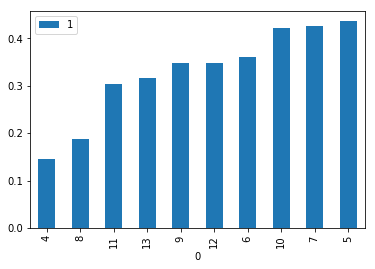

In [48]:
# Visualizing similarity of the first 10 beers based on average ratings given to the beers
beer_scores = {}
for i in range(10):
  beer_scores[item_final_rating.columns[i]] = item_final_rating.iloc[:,i].mean()

pd.DataFrame(sorted(beer_scores.items(), key = lambda kv:(kv[1], kv[0]))).plot.bar(x=0,y=1)

**Summary**:
1. Beer ID 4 and 8 are low rated (<2)
2. Beer ID 11, 13, 9 and 12 are are average rated (between 3 and 4)
3. Beer ID 10, 7 and 5 are high rated (above 4)

## Evaluation

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the beers already rated by the user insead of predicting it for the beers not rated by the user. 

## Using User Similarity

In [49]:
test_user_beer_rating = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_user_beer_rating, axis=1)
test_df_subtracted = (test_user_beer_rating.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine', n_jobs=-1)
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.9999999 0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


In [50]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_user_beer_rating.fillna(0))
test_user_predicted_ratings

array([[0.        , 0.30763856, 0.35320282, ..., 0.        , 0.14326435,
        0.        ],
       [0.        , 0.69562936, 0.14842087, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13812566, 0.89483905, 0.5855597 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### Doing prediction for the beers rated by the user

In [0]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [52]:
test_user_final_rating.head()

beer_beerid,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,63,...,74530,74548,74579,74582,74591,74625,74634,74640,74759,74783,74815,74827,74854,74900,74904,74906,74942,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0runkp0s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000Bottles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the RMSE for only the beers rated by user. For  RMSE, normalising the rating to (1,5) range. 

In [53]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [0]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [0]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [56]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.8782841185250485


## Using Item similarity

In [0]:
test_user_final_rating = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_user_final_rating, axis=1)
test_df_subtracted = (test_user_final_rating.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine', n_jobs=-1)
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [58]:
test_item_correlation.shape

(9453, 9453)

In [59]:
test_user_final_rating.shape

(9453, 13794)

In [60]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_user_final_rating.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

beer_beerid,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,24,26,27,29,30,31,32,33,34,36,39,40,42,44,50,51,52,54,55,56,58,59,61,63,...,74530,74548,74579,74582,74591,74625,74634,74640,74759,74783,74815,74827,74854,74900,74904,74906,74942,74986,75009,75013,75048,75084,75086,75160,75188,75230,75465,75474,75499,75502,75548,75739,75828,75894,75978,76144,76323,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0runkp0s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000Bottles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [62]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(copy=True, feature_range=(1, 5))


In [63]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.2845008738575117


## Chosing the Model that should be deployed

Based on above evaluation, we would prefer deploying User Similarity based Model for the following reasons:


1.   Lower RSME value
2.   Business Understanding (poeple may try new beer based on what similar people have rated, considering factors like country, state, finances, etc.)



## Top 5 beers recommendation

### User Similarity based Recommendation


Users: 'cokes', 'genog' and 'giblet'

In [64]:
# User Similarity based Beer Recommendation for user 'cokes'
user_final_rating[user_final_rating.index=='cokes'].T.sort_values(by='cokes',ascending=False)[0:5]

review_profilename,cokes
beer_beerid,
4083,29.202168
412,27.866737
1904,25.267250
11757,22.820625
92,22.644302


In [65]:
# User Similarity based Beer Recommendation for user 'genog'
user_final_rating[user_final_rating.index=='genog'].T.sort_values(by='genog',ascending=False)[0:5]

review_profilename,genog
beer_beerid,
1093,34.296001
2093,33.051388
1904,32.426132
276,32.179893
1005,29.828575


In [66]:
# User Similarity based Beer Recommendation for user 'giblet'
user_final_rating[user_final_rating.index=='giblet'].T.sort_values(by='giblet',ascending=False)[0:5]

review_profilename,giblet
beer_beerid,
412,39.103222
276,37.917728
1904,35.398716
92,35.101746
104,34.789059


### Item Similarity based Recommendation
Users: 'cokes', 'genog' and 'giblet'

In [67]:
# Item Similarity based Beer Recommendation for user 'cokes'
item_final_rating[user_final_rating.index=='cokes'].T.sort_values(by='cokes',ascending=False)[0:5]

review_profilename,cokes
beer_beerid,
9490,18.650629
2307,17.884983
37610,17.772249
3980,17.605125
11925,17.303144


In [68]:
# Item Similarity based Beer Recommendation for user 'genog'
item_final_rating[user_final_rating.index=='genog'].T.sort_values(by='genog',ascending=False)[0:5]

review_profilename,genog
beer_beerid,
45249,6.383133
38774,6.160038
21491,5.793401
39965,5.741158
60588,5.716785


In [69]:
# Item Similarity based Beer Recommendation for user 'giblet'
item_final_rating[user_final_rating.index=='giblet'].T.sort_values(by='giblet',ascending=False)[0:5]

review_profilename,giblet
beer_beerid,
10100,6.020452
37294,4.970554
3664,4.896687
4032,4.794988
41524,4.716740


## Summary of Recommendation of beers for given users

**cokes** (By User Similarity): 4083, 412, 1904,11757, 92

**cokes** (By Item Similarity): 9490, 2307, 37610, 3980, 11925


**genog** (By User Similarity): 1093, 2093, 1904, 276, 1005

**genog** (By Item Similarity): 45249, 38774, 21491, 39965, 60588


**giblet** (By User Similarity): 412, 276, 1904, 92, 104

**giblet** (By Item Similarity): 10100, 37294, 3664, 4032, 41524

**We observe that a number of beers are repeated in recommendation for User Based Similarity**


**We observe that mostly new beers are in recommendation for Item Based Similarity**


**We would use User Based Similarity Recommendation Model in production since it has 1) Lower RSME value and 2) Business Understanding (poeple may try new beer based on what similar people have rated, considering factors like country, state, finances, etc.)**